In [ ]:
!pip install --upgrade numerapi

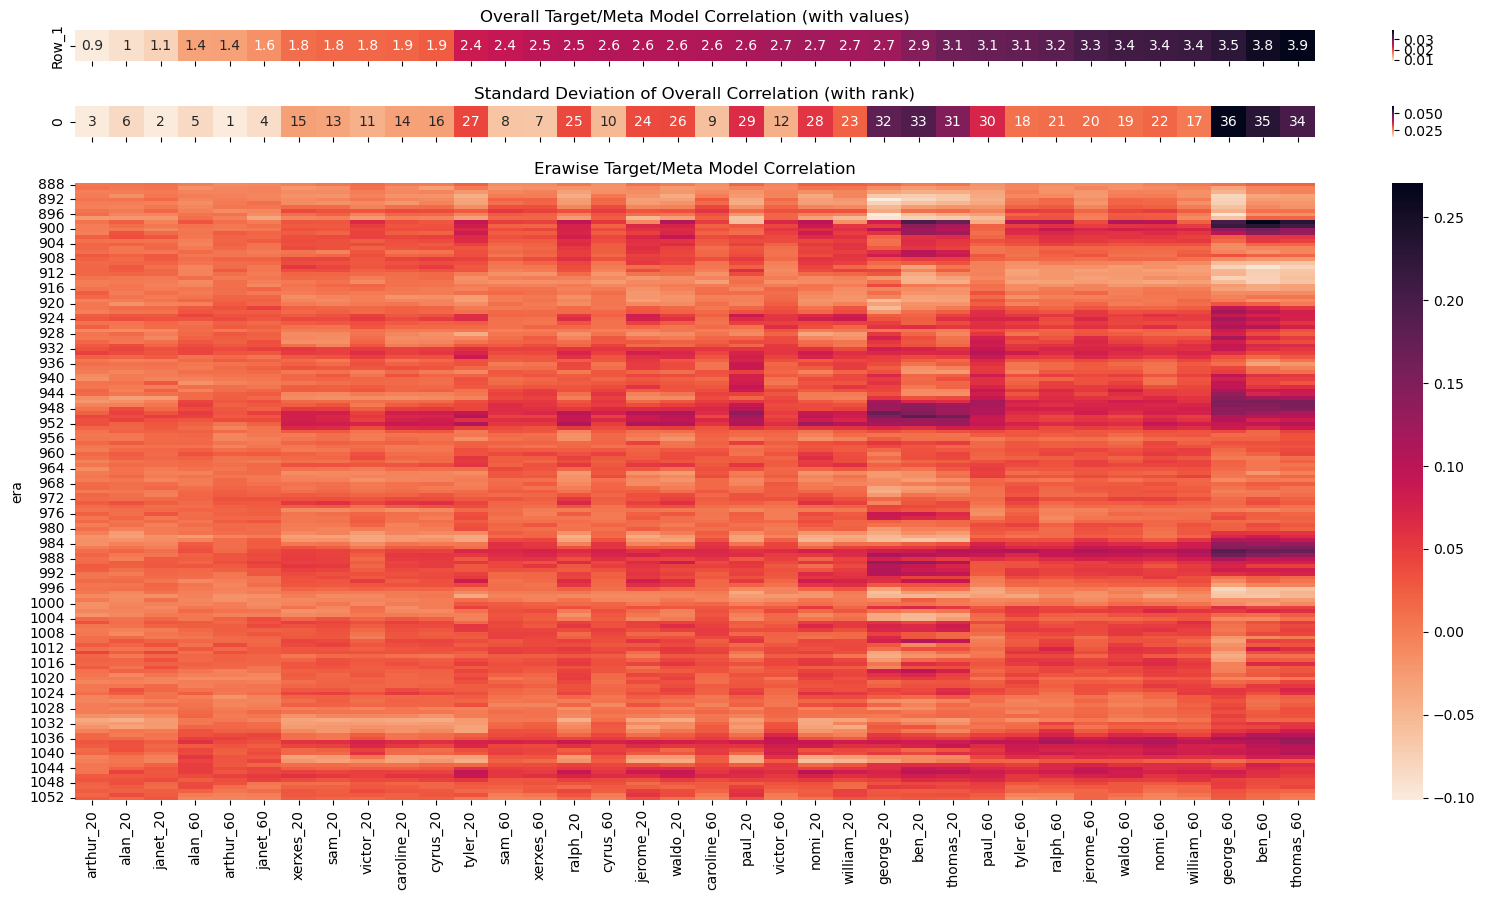

In [6]:
import numerapi
napi = numerapi.NumerAPI()
napi.download_dataset("v4.1/validation.parquet", "validation.parquet")
napi.download_dataset("v4.1/meta_model.parquet", "meta_model.parquet")
import pyarrow.parquet as pq
import pandas as pd
md = pq.read_metadata('validation.parquet')
tgt_cols = [i for i in md.schema.names if i.startswith('target')]
val_df = pq.read_table('validation.parquet',columns=(['id','era']+tgt_cols),).to_pandas().astype({'era': 'int32'})
val_df = val_df.drop(columns=['target'])
val_df = val_df[(val_df.era>=888)&(val_df.era<=1052)] #888 to 1038 represents the eras with labled meta data and targets
mm_df = pq.read_table('meta_model.parquet').to_pandas().astype({'era': 'int32'})
mm_df = mm_df[(mm_df.era>=888)&(mm_df.era<=1052)]
mm_df.drop(columns=['data_type','era'])
df = pd.concat([val_df,mm_df.numerai_meta_model], axis=1)
del val_df, mm_df
new_cols={}
for col in df.columns:
    new_cols.update({col:col.replace('target_','')})
df = df.rename(new_cols, axis='columns')
for col in df.columns:
    new_cols.update({col:col.replace('v4_','')})
df = df.rename(new_cols, axis='columns')
df = df.rename({'numerai_meta_model':'meta_model'}, axis='columns')
overall_corr = df.corrwith(df.meta_model).to_frame().transpose().drop(columns=['era','meta_model'])
erawise_corr = df.groupby('era').corrwith(df.meta_model).drop(columns=['meta_model'])
overall_corr = overall_corr.sort_values(by=0,axis=1).rename(index={0: 'Row_1'})
erawise_corr = erawise_corr[overall_corr.columns.tolist()]
ew_std = erawise_corr.std().to_frame().transpose()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
fig, axes = plt.subplots(3, 1, figsize=(20,10), gridspec_kw={'height_ratios':[1,1,20]}, sharex=True)
axes[0].set_title('Overall Target/Meta Model Correlation (with values)')
axes[1].set_title('Standard Deviation of Overall Correlation (with rank)')
axes[2].set_title('Erawise Target/Meta Model Correlation')
sns.heatmap(overall_corr, ax=axes[0], cmap='rocket_r', xticklabels=False, annot=round(overall_corr*100,1))
sns.heatmap(ew_std,       ax=axes[1], cmap='rocket_r', xticklabels=False, annot=ew_std.rank(axis='columns',).astype('int'))
sns.heatmap(erawise_corr, ax=axes[2], cmap='rocket_r')
pass